# Import libraries

In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pytse_client as tse
from pytse_client.download import download_financial_indexes

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from zigzag import peak_valley_pivots

# Import data

In [116]:
marketIndex = download_financial_indexes(symbols = 'شاخص كل', write_to_csv = True, include_jdate = True)
marketIndex = marketIndex['شاخص كل']
marketIndex.rename(columns = {'value': 'TEDPIX'}, inplace = True)
print(f'Shape of TEDPIX: {marketIndex.shape}')
marketIndex.head()

Shape of TEDPIX: (3313, 3)


,jdate,TEDPIX,date
0,1387-09-14,9248.9,2008-12-04
1,1387-09-15,9248.9,2008-12-05
2,1387-09-16,9178.3,2008-12-06
3,1387-09-17,9130.5,2008-12-07
4,1387-09-18,9089.2,2008-12-08


In [117]:
#sipa = tse.download(symbols = ["خساپا"], write_to_csv = False, include_jdate = True)

tse.download(symbols = ['فولاد'], write_to_csv = True, include_jdate = True)
folad = tse.Ticker(symbol = 'فولاد',  adjust = True)
foladHist = folad.history
print(f'Shape of Folad price history: {foladHist.shape}')
foladHist.head()

Shape of Folad price history: (3402, 10)


,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [118]:
foladClient = folad.client_types
print(f"Shape of Folad's client history: {foladClient.shape}")
foladClient.head()

Shape of Folad's client history: (3017, 18)


,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20220824,2433,6,1074,20,64053172,4646244,30822456,37876960,341124731740,24763337000,164155081290,201732987450,5325.649317,5325.827419,5329.753883,5326.007881,33230716.0
1,20220823,3106,9,1543,16,58082075,4311154,51648211,10745018,306312873330,22809816550,272453128290,56669561590,5273.793564,5275.170679,5290.884192,5274.031332,6433864.0
2,20220822,3142,14,2325,19,53617738,63434673,90419949,26632462,284791650860,337082647520,480526551820,141347746560,5311.519312,5314.386450,5313.854893,5307.348099,-36802211.0
3,20220821,804,5,543,13,14613369,50180431,29272091,35521709,79223308920,272090954050,158710993540,192603269430,5421.289842,5421.921978,5422.252233,5422.128463,-14658722.0
4,20220817,2182,6,1255,13,35782991,40423190,36732725,39473456,198581293870,225335751500,204119827160,219797218210,5549.600196,5556.893129,5574.417840,5568.228386,-949734.0


# Data pre-processing

In [119]:
foladHist.insert(1,'step', np.arange(1, len(foladHist) + 1))
foladHist = pd.merge(foladHist, marketIndex, how = 'left', on = 'date')

cols = ['date', 'jdate', 'step', 'TEDPIX',
        'open', 'close', 'high', 'low', 'adjClose', 
        'value', 'volume', 'count', 'yesterday']
foladHist = foladHist[cols]

foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0


In [120]:
foladClient['date'] = pd.to_datetime(foladClient['date'])
foladClient.iloc[:, 1: 13] = foladClient.iloc[:, 1: 13].astype('float')

foladClient['Enter_individual_money'] = foladClient['individual_buy_value'] - foladClient['individual_sell_value']
foladClient['Individual_buy_per_capita'] = foladClient['individual_buy_value'] / foladClient['individual_buy_count']
foladClient['Individual_sell_per_capita'] = foladClient['individual_sell_value'] / foladClient['individual_sell_count']
foladClient['Individual_buy_power_to_Individual_sell'] = foladClient['Individual_buy_per_capita'] / foladClient['Individual_sell_per_capita']

foladClient.head()

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,...,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell
0,2022-08-24,2433.0,6.0,1074.0,20.0,64053172.0,4646244.0,30822456.0,37876960.0,3.411247e+11,...,2.017330e+11,5325.649317,5325.827419,5329.753883,5326.007881,33230716.0,1.769697e+11,1.402075e+08,1.528446e+08,0.917320
1,2022-08-23,3106.0,9.0,1543.0,16.0,58082075.0,4311154.0,51648211.0,10745018.0,3.063129e+11,...,5.666956e+10,5273.793564,5275.170679,5290.884192,5274.031332,6433864.0,3.385975e+10,9.861973e+07,1.765736e+08,0.558519
2,2022-08-22,3142.0,14.0,2325.0,19.0,53617738.0,63434673.0,90419949.0,26632462.0,2.847917e+11,...,1.413477e+11,5311.519312,5314.386450,5313.854893,5307.348099,-36802211.0,-1.957349e+11,9.064025e+07,2.066781e+08,0.438558
3,2022-08-21,804.0,5.0,543.0,13.0,14613369.0,50180431.0,29272091.0,35521709.0,7.922331e+10,...,1.926033e+11,5421.289842,5421.921978,5422.252233,5422.128463,-14658722.0,-7.948768e+10,9.853645e+07,2.922854e+08,0.337124
4,2022-08-17,2182.0,6.0,1255.0,13.0,35782991.0,40423190.0,36732725.0,39473456.0,1.985813e+11,...,2.197972e+11,5549.600196,5556.893129,5574.417840,5568.228386,-949734.0,-5.538533e+09,9.100884e+07,1.626453e+08,0.559554


In [121]:
foladHist = pd.merge(foladHist, foladClient.iloc[:, [0, -4, -3, -2, -1]], how = 'left', on = 'date')
foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,NaN,NaN,NaN,NaN
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,NaN,NaN,NaN,NaN
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,NaN,NaN,NaN,NaN
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,NaN,NaN,NaN,NaN
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,NaN,NaN,NaN,NaN


# ZigZag

In [149]:
pivots = peak_valley_pivots(foladHist['adjClose'], -0.1, -0.1)
foladHist['label'] = pivots
foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell,label
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,NaN,NaN,NaN,NaN,-1
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,NaN,NaN,NaN,NaN,0
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,NaN,NaN,NaN,NaN,0
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,NaN,NaN,NaN,NaN,0
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,NaN,NaN,NaN,NaN,0


([<matplotlib.patches.Wedge at 0x1efd240e1a0>,
 [Text(-1.0874092656900491, 0.1659550809448996, '0'),
  Text(1.071966819869603, -0.24675319065546056, '-1'),
  Text(1.0969241835191235, -0.0822030146095901, '1')])

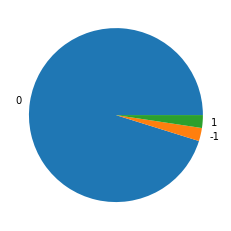

In [148]:
plt.pie(
    foladHist['label'].value_counts(),
    labels = foladHist['label'].value_counts().index
)

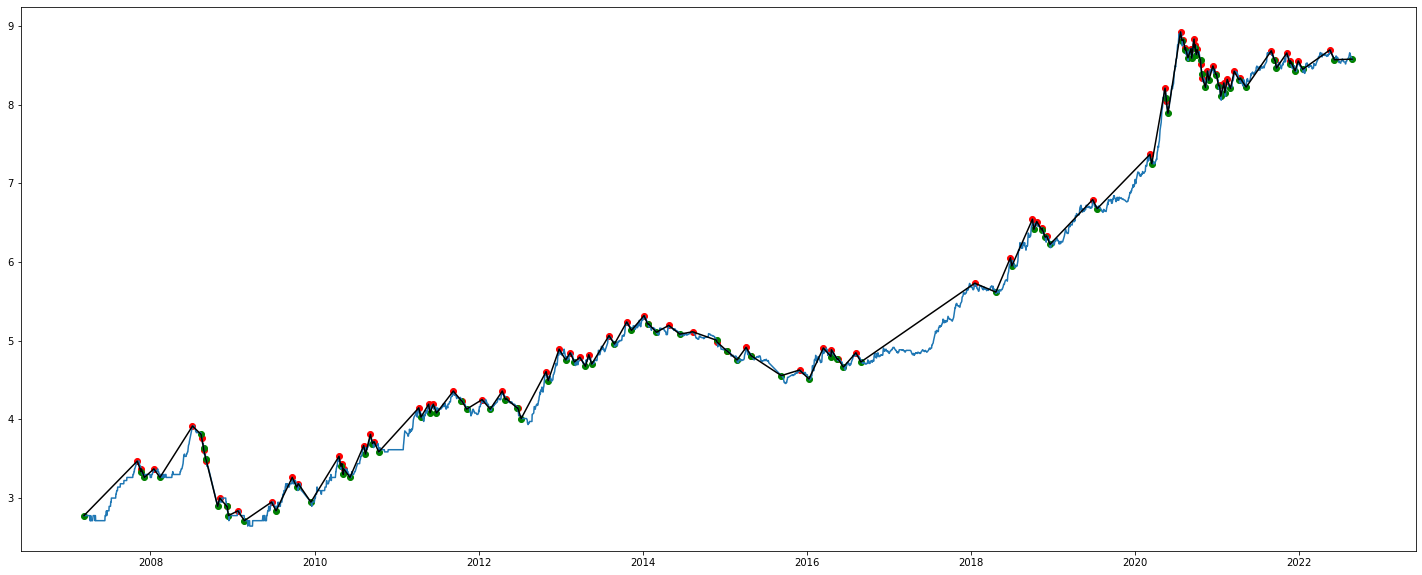

In [150]:
plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][pivots != 0], np.log(foladHist['adjClose'][pivots != 0]), 'k-')
plt.scatter(foladHist['date'][pivots == 1], np.log(foladHist['adjClose'][pivots == 1]), color='r')
plt.scatter(foladHist['date'][pivots == -1], np.log(foladHist['adjClose'][pivots == -1]), color='g')

# Rolling

In [124]:
'''
window = 100
foladHist['rolling lable'] = 0

foladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()
foladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1

foladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()
foladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1

plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')
'''

"\nwindow = 100\nfoladHist['rolling lable'] = 0\n\nfoladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()\nfoladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1\n\nfoladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()\nfoladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1\n\nplt.figure(figsize = (25, 10))\nplt.plot(foladHist['date'], np.log(foladHist['adjClose']))\n\nplt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')\nplt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')\nplt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')\n"

# Model

In [160]:
foladHist = foladHist.dropna(axis = 0, how = 'any')
X = foladHist.iloc[:, 2:-1].values
y = foladHist.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    shuffle = False,
    random_state = 0
)

In [161]:
rfc = RandomForestClassifier(
    n_estimators = 100, 
    criterion = 'entropy', 
    class_weight = 'balanced',
    random_state = 0)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       random_state=0)

<AxesSubplot:>

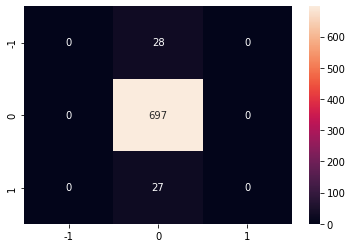

In [167]:
y_pred = rfc.predict(X_test)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot = True,
    fmt = 'g',
    xticklabels = [-1, 0, 1], 
    yticklabels = [-1, 0, 1]
)

In [169]:
fig = make_subplots(
    rows = 2, 
    cols = 1, 
    shared_xaxes = True, 
    vertical_spacing = 0.03, 
    subplot_titles = ('OHLC', 'Volume'), 
    row_width = [0.2, 0.7]
)

fig.add_trace(
    go.Candlestick(
        x = foladHist['date'],
        open = foladHist['open'],
        high = foladHist['high'],
        low = foladHist['low'],
        close = foladHist['adjClose']
    ),
    row = 1, col = 1
)

fig.add_trace(
    go.Bar(
        x = foladHist['date'],
        y = foladHist['volume'], 
        showlegend = False
        ),
        row = 2, col = 1
)
fig.update(layout_xaxis_rangeslider_visible = False)
fig.show()